# 根据单变量房屋面积预测价格


In [1]:
house_data = [
2104,3,399900,
1600,3,329900,
2400,3,369000,
1416,2,232000,
3000,4,539900,
1985,4,299900,
1534,3,314900,
1427,3,198999,
1380,3,212000,
1494,3,242500,
1940,4,239999,
2000,3,347000,
1890,3,329999,
4478,5,699900,
1268,3,259900,
2300,4,449900,
1320,2,299900,
1236,3,199900,
2609,4,499998,
3031,4,599000,
1767,3,252900,
1888,2,255000,
1604,3,242900,
1962,4,259900,
3890,3,573900,
1100,3,249900,
1458,3,464500,
2526,3,469000,
2200,3,475000,
2637,3,299900,
1839,2,349900,
1000,1,169900,
2040,4,314900,
3137,3,579900,
1811,4,285900,
1437,3,249900,
1239,3,229900,
2132,4,345000,
4215,4,549000,
2162,4,287000,
1664,2,368500,
2238,3,329900,
2567,4,314000,
1200,3,299000,
852,2,179900,
1852,4,299900,
1203,3,239500]

## 读取数据 读到df0，并绘制2D图形

In [17]:
# 数据处理包
import pandas as pd
# 2D绘图工具
import matplotlib as mplot
# 2D高阶绘图工具
import seaborn as sns
# 设置格式
sns.set(context="notebook",style="whitegrid",palette="dark")
# 3D绘图工具
import mpl_toolkits.mplot3d as mplot3d
# 读取csv
df0 = pd.read_csv("./house-data.csv",names=["square","bedroom","price"])
# 绘图，lmplot是专门用于线性关系可视化的
sns.lmplot("square","price",df0,height=6,fit_reg=True)

TypeError: lmplot() takes from 0 to 1 positional arguments but 3 positional arguments (and 2 keyword-only arguments) were given

## 用3D的方式画散点，进行归一化并赋值到df

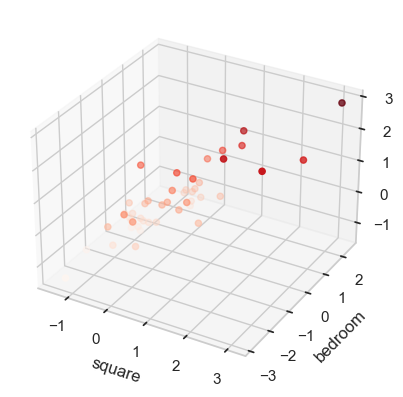

In [7]:
import matplotlib.pyplot as plt
# lambda进行归一化 (值-均值)/方差
def normalize_feature(df):
    return df.apply(lambda column:(column-column.mean())/column.std())
df = normalize_feature(df0)
fig = plt.figure()
# 用于绘制3D图像
ax = plt.axes(projection="3d")
ax.set_xlabel("square")
ax.set_ylabel("bedroom")
ax.set_zlabel("price")
# Axes3D.scatter3D是专门用来绘制散点图的
ax.scatter3D(df["square"],df["bedroom"],df["price"],c=df["price"],cmap="Reds")


## 数据处理 处理结果放到df2

In [8]:
import numpy as np
# 构建一个df那么长的，1列数据，并且赋值都为1，名字叫ones
ones = pd.DataFrame({'ones':np.ones(len(df))})
# 把之前的df和ones合并在一起，根据列进行合并，从左到右的进行合并
df2 = pd.concat([ones,df],axis=1)
# 取出df2的前三列，并转化为pd数组
x_data=np.array(df2[df2.columns[0:3]])
# 取出df2的最后一列，并进行形状变化，变成df2那么多行，1列的数据窗
y_data=np.array(df2[df2.columns[-1]]).reshape(len(df2),1)
print(x_data.shape,type(x_data))
print(y_data.shape,type(y_data))

(47, 3) <class 'numpy.ndarray'>
(47, 1) <class 'numpy.ndarray'>


## 创建线性回归模型（数据流图）

In [15]:
import tensorflow.compat.v1 as tf
# 必须要加这句话，否则placeholder会报错
tf.compat.v1.disable_eager_execution()

# 学习率
alpha=0.01
# 训练代数
epoch=500
# 定义X的形状[47,3]
with tf.name_scope('input'):
    X = tf.placeholder(tf.float32,x_data.shape)
    # 定义结果变量的形状[47,1]
    y=tf.placeholder(tf.float32,y_data.shape)
    # 必须加这句话，否则会发现weights被重复定义了

with tf.name_scope('hypothesis'):
    with tf.variable_scope("weights", reuse=tf.AUTO_REUSE):
    #     权重变量，形状[3,1]
        W=tf.get_variable("weights",(x_data.shape[1],1),initializer=tf.constant_initializer())
    #     假设函数h(x)=w0*x0+w1*x1+w2*x2,其中x0恒为1，x1,x2就分别是square和bedroom，W就是我们要求的模型
    # 推理值 y_pred的形状是[47,1]
    y_pred=tf.matmul(X,W)
    
with tf.name_scope('loss'):
    #     损失函数，采用最小二乘法 y_pred-y 是[47,1]的向量
    # 这句话的含义是矩阵a的转置再乘以矩阵b，[1,47] * [47,1]，transpose_a表示的是对第一个矩阵进行转置
    # 这句话的含义是，把47个样本的损失值做了一个累加。前面的len(x_data)表示的数量，相当于求了一个平均值
    # 损失函数loss
    loss_op = 1/(2*len(x_data))*tf.matmul((y_pred-y),(y_pred-y),transpose_a=True)
with tf.name_scope('train'):
    #     随机梯度下降优化器opt
    opt=tf.train.GradientDescentOptimizer(learning_rate=alpha)

    #     单步训练操作
    train_op=opt.minimize(loss_op)

In [18]:
# 创建会话
with tf.Session() as sess:
#     初始化全局变量
    sess.run(tf.global_variables_initializer())
#     把当前绘画的数据流图都保存在这里
    writer = tf.summary.FileWriter('./summary/liner-regression-1',sess.graph)
#     因为训练量小，所以采用批梯度下降优化算法，每次采用全量数据训练
    for e in range(1,epoch+1):
        sess.run(train_op,feed_dict={X:x_data,y:y_data})
        if e % 10 ==0:
            loss,w = sess.run([loss_op,W],feed_dict={X:x_data,y:y_data})
            log_str="Epoch %d \t loss=%.4g \t Model:y = %.4gx1+%.4gx2+%.4g"
            print(log_str%(e,loss,w[1],w[2],w[0]))
# 关闭FilwWriter的流信息
writer.close()

Epoch 10 	 loss=0.4116 	 Model:y = 0.0791x1+0.03948x2+3.353e-10
Epoch 20 	 loss=0.353 	 Model:y = 0.1489x1+0.07135x2+-5.588e-11
Epoch 30 	 loss=0.3087 	 Model:y = 0.2107x1+0.09676x2+3.912e-10
Epoch 40 	 loss=0.2748 	 Model:y = 0.2655x1+0.1167x2+-1.863e-11
Epoch 50 	 loss=0.2489 	 Model:y = 0.3142x1+0.1321x2+1.77e-10
Epoch 60 	 loss=0.2288 	 Model:y = 0.3576x1+0.1436x2+-4.47e-10
Epoch 70 	 loss=0.2131 	 Model:y = 0.3965x1+0.1519x2+-8.941e-10
Epoch 80 	 loss=0.2007 	 Model:y = 0.4313x1+0.1574x2+-6.24e-10
Epoch 90 	 loss=0.1908 	 Model:y = 0.4626x1+0.1607x2+-4.191e-10
Epoch 100 	 loss=0.1828 	 Model:y = 0.4909x1+0.1621x2+-5.402e-10
Epoch 110 	 loss=0.1763 	 Model:y = 0.5165x1+0.162x2+-7.125e-10
Epoch 120 	 loss=0.1709 	 Model:y = 0.5397x1+0.1606x2+-5.076e-10
Epoch 130 	 loss=0.1664 	 Model:y = 0.5609x1+0.1581x2+-8.335e-10
Epoch 140 	 loss=0.1625 	 Model:y = 0.5802x1+0.1549x2+-9.22e-10
Epoch 150 	 loss=0.1592 	 Model:y = 0.5979x1+0.1509x2+-9.011e-10
Epoch 160 	 loss=0.1564 	 Model:y = 0.61

## TensorBoard可视化工具